# 逻辑回归

Minimal,  System, Insight, Programming

---

逻辑回归与线性回归均属于**广义线性模型**，区别在于线性回归用于解决回归问题，例如身高、销量等连续变量预测，逻辑回归用于二分类问题，例如判断是否为垃圾邮件，客户是否会点击广告。本章我们将首先了解**最大似然估计**，一步步推导出逻辑回归模型，最大似然估计广泛用于各类机器学习、深度学习，需要认真理解。接着会以实际案例，讲解非结构化数据处理的基础方法，分类问题建模流程。

学习目标：
- 最大似然估计
- 逻辑回归模型
- 常用的分类问题评价指标
- 基础数据处理&分类问题建模
- 独自完成Kaggle Titanic竞赛首次提交，得分需要高于0.75；


配套视频：[阿里云盘](https://www.aliyundrive.com/s/oZ35bk4A3Je) | [Dropbox](https://www.dropbox.com/s/v03c51064w43lus/%E9%80%BB%E8%BE%91%E5%9B%9E%E5%BD%92.mp4?dl=0)


# 最大似然估计


硬币有正反两面，如果硬币正反两面是均匀的，即每次抛掷后硬币为正的概率是0.5。使用这个硬币，很可能抛10次，有5次是正面。但是假如有人对硬币做了手脚，比如提前对硬币做了修改，硬币正面朝上概率大幅度提升了，你拿到硬币在尝试抛了10次，结果8次都是正面，如何估算下次硬币为正的概率呢？

### 概率

现在我们可以做出猜测，假设硬币出现正面概率的参数$\theta$分别等于(0.6,0.7,0.8)，那么这三种硬币参数下，出现“8正2反”的整体概率分别是多少呢：

$$P(8正2反|\theta) = C_{10}^{2}(1-\theta)^2 * \theta^8$$

In [1]:
import numpy as np

print(f"theta = 0.6,  概率为{10*9/2 * np.power(1-0.6, 2) * np.power(0.6, 8):.3}")

print(f"theta = 0.7,  概率为{10*9/2 * np.power(1-0.7, 2) * np.power(0.7, 8):.3}")

print(f"theta = 0.8,  概率为{10*9/2 * np.power(1-0.8, 2) * np.power(0.8, 8):.3}")

theta = 0.6,  概率为0.121
theta = 0.7,  概率为0.233
theta = 0.8,  概率为0.302


**可以看出，我们假设硬币朝正面参数为0.8的时候，出现8正2反情况的概率最大。我们有理由相信，0.8是候选的3个参数中的最接近真实概率的选项。**

### 似然函数(likelihood function)

在上面的尝试中，0.8似乎是一个不错的猜测没，，但是否可能是0.81或者0.79呢，我们当然可以按照上面的方法再次计算概率，但是问题是我们无法遍历整个空间。因此我们需要定义一个函数来表示不同的参数$\theta$下，表示多个独立事件$(x_1, x_2, .., x_n)$发生的整体概率，这个函数我们叫它**似然函数(likelihood function， 通常用L表示)**，其中组合数部分是常数，我们可以直接忽略。

$$L(x_1, x_2, ..., x_n|\theta) = \prod_{1}^{n}p(x_i|\theta)$$

似然函数通常用L表示,观察到抛硬币“8正2反”的事实，硬币参数$\theta$取不同值时，似然函数表示为：
$$L(8正2反|\theta) = (1- \theta)^2 * \theta^8$$

通过似然函数，我们只要能找到使得似然函数最大（多个独立事件$(x_1, x_2, .., x_n)$发生的整体概率最大化）的$\theta$，就可以完成对硬币参数的估计了，这就是最大似然估计：

$$\hat{\theta} = argmax_{\theta}\prod_{1}^{n}p(x_i|\theta)$$


### 最大似然估计

通常，由于似然函数为连乘，会造成小数位过高，无法有效表示，我们采用对数似然函数进行表示，把连乘转化为累加形式：

$$l(x_1, x_2, ..., x_n|\theta) = \sum_{1}^{n}log p(x_i|\theta)$$

$$\hat{\theta} = argmax_{\theta}\sum_{1}^{n}log p(x_i|\theta)$$

# 逻辑回归

逻辑回归是线性分类模型，说线性是因为其决策边界是线性的（平面或超平面），模型输出值域为(0, 1)，通常我们将输出结果视为属于正样$(y=1)$的概率。我们先来看一下逻辑回归模型的数学表示：

$$ P(x) = \sigma(w^Tx) = \frac{1}{1+exp^{-w^Tx}}$$

与线性回归类似，$x$为样本特征，为了表示方便，类似的增加一个bias维度，值为1，$w$为模型系数，函数$\sigma(\theta)=\frac{1}{1+exp^{-\theta}}$被称为$sigmoid$函数，其函数图像如下所示。可以发现$sigmoid$函数具备一些比较良好的特性，首先其输出值域为(0,1)，可以直接视作为正样本概率，其次其梯度在0附近最大，可以在梯度下降优化过程中，更加到聚焦到较难分类的样本上。

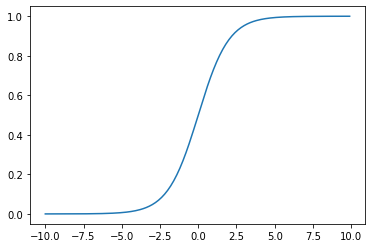

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

data = np.arange(-10, 10, 0.1)
plt.plot(data, sigmoid(data))

## 逻辑回归的似然函数与梯度

**tips: 本段包含了不少公式计算，但公式本身的推导细节并不是最重要的，最重要的是通过引入似然函数，我们构造了逻辑回归的损失函数，且该损失函数可以利用梯度下降进行优化。**

对逻辑回归模型的数学表示有一个基本认识后，我们来思考一个问题，我们应该怎么去优化模型参数？ 假设我们有$n$个样本$(x^1, x^2,...,x^n)$,其对应标签为$(y^1,...,y^n)$且任意$y^i \in {0,1}$，根据最大似然原理，我们可以用逻辑回归表示出所有n个样本的似然函数，并使之最大化。对于单个样本$(x^i, y^i)$, 模型预测结果与样本真实标签一致的概率为：
$$p(y=y^i|x^i)=p(x^i)^{y^i} (1-p(x^i))^{1-y^{i}}$$

这里我们讨了个巧，因为$y^i$只有可能等于0或1,所以当$y^i=1$的时候，第二项等于1,当$y^i=0$的时候，第一项等于1,通过这种设计我们可以把$y^i$分别等于0或1的两种情况写在一个公式里，好了，这里是样本$i$模型预测结果与样本真实标签一致的概率，那么假设样本是独立的（机器学习模型对于样本都有IID即独立同分布假设），样本总体的模型预测结果与样本真实标签一致的概率为：

$$Likelihood = \prod_i{p(y=y^i|x^i)=\prod_i{p(x^i)^{y^i}} (1-p(x^i))^{1-y^{i}}}$$

两边同时取对数，对数似然函数为：

$$loglikelihood = \sum_i[{y^ilogp(x^i)} + (1-y^{i})log(1-p(x^i))]$$

$$loglikelihood = \sum_i[{y^ilog\frac{p(x^i)}{1-p(x^i)}} + log(1-p(x^i))]$$

那么这个对数似然函数就是我们需要优化的目标的，其值越大越好，越大说明模型预测概率和真实发生概率一致性越高。由于梯度下降法是验证最小化损失函数目标进行的，因此我们对对数似然函数乘以-1。

$$ J(w) = -\sum_i[{y^ilog\frac{p(x^i)}{1-p(x^i)}} + log(1-p(x^i))]$$

求关于参数的梯度,根据求导法则可得：

$$ g = \frac{\partial{J}}{\partial{w}}= \sum_i (p(x^i)-y^i)*x^i$$

有了梯度，根据上节课我们学习的梯度下降，就可以根据学习率$\alpha$逐步迭代更新模型参数:
$$ w = w - \alpha * g$$

# 分类问题常用评价指标

在二分类场景，模型所有的预测结果可以分为四类：
1. TP（True positive)，意思是模型预测为正样本（Positive），预测是正确的（True）
2. FP（False positive），意思是模型预测为正样本（Positive），预测是错误的（False）
3. TN（True negtive），意思是模型预测为负样本（negtive），预测是正确的（True）
3. FN（False negtive），意思是模型预测为负样本（negtive），预测是错误的（False）

基于以上四类预测结果，我们可以定义指标：

- 准确率 $Accuracy = \frac{\#TP + \#TN}{\# ALL}$ ，简单理解就是，所有预测结果中，预测正确的比例，值越大说明模型表现越好。

- 精准率 $precision = \frac{\#TP}{\#TP+\#FP}$，所有预测的正样本，正确的比例，值越大说明模型表现越好。

- 召回率 $recall  = \frac{\#TP}{\#TP+\#FN} $，所有正样本被正确预测的比例，值越大说明模型表现越好。

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [14]:
y_true = [1, 1, 0, 1, 0]
y_pred = [0, 1, 0, 1, 0]

In [15]:
accuracy_score(y_true, y_pred)

0.8

In [16]:
precision_score(y_true, y_pred)

1.0

In [17]:
recall_score(y_true, y_pred)

0.6666666666666666

在一些极端场景下，准确率会失效，比如正负样本及其不均匀的情况：

In [18]:
y_true = [1, 1, 1, 1, 1, 0]
y_pred = [1, 1, 1, 1, 1, 1]

In [19]:
accuracy_score(y_true, y_pred)

0.8333333333333334

不过什么输入，模型都预测为正样本，导致模型本质上没有预测能力，但是依然能够取得很高的Accuracy。为了避免评估指标失效，我们可以同时查看precision 和 recall指标。

In [22]:
precision_score(y_true, y_pred)

0.8333333333333334

In [23]:
recall_score(y_true, y_pred)

1.0

也可以应用一个由recall, precision 一起组成的复合指标 f1-score，该值越大，说明模型表现越好:

$$f1 = \frac{2*recall*precision}{recall+precision}$$

In [24]:
from sklearn.metrics import f1_score

In [25]:
f1_score(y_true, y_pred)

0.9090909090909091

In [26]:
p = precision_score(y_true, y_pred)
r = recall_score(y_true, y_pred)

2 * p * r / (p + r)

0.9090909090909091

# 项目案例

[Titanic - Machine Learning from Disaster
](https://www.kaggle.com/competitions/titanic/overview)竞赛案例。

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

%matplotlib inline

In [4]:
!ls ./titanic

gender_submission.csv  test.csv  train.csv


In [6]:
train = pd.read_csv("./titanic/train.csv")
test = pd.read_csv("./titanic/test.csv")
submission = pd.read_csv("./titanic/gender_submission.csv")

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train.shape

(891, 12)

In [9]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
test.shape

(418, 11)

In [11]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [12]:
train.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [14]:
train.dtypes.value_counts()

int64      5
object     5
float64    2
dtype: int64

In [16]:
train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

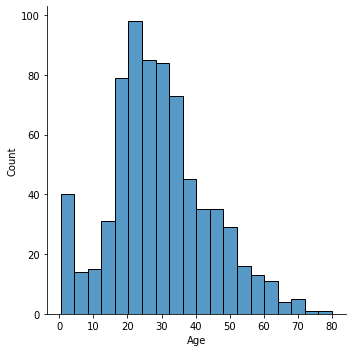

In [18]:
sns.displot(train.Age)

<AxesSubplot:xlabel='Age'>

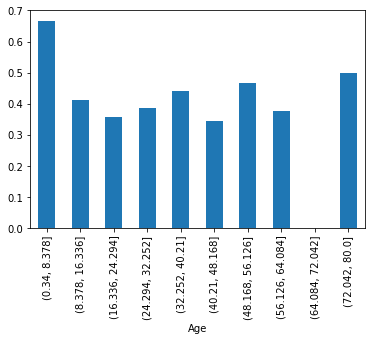

In [21]:
train.groupby(pd.cut(train.Age, bins=10))\
["Survived"].mean().sort_index().plot(kind="bar")

In [22]:
train.groupby("Sex")["Survived"].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [23]:
train.groupby("Embarked")["Survived"].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [24]:
train.groupby("Embarked")["Fare"].mean()

Embarked
C    59.954144
Q    13.276030
S    27.079812
Name: Fare, dtype: float64

<AxesSubplot:xlabel='SibSp'>

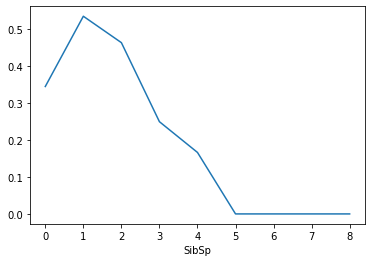

In [26]:
train.groupby("SibSp")["Survived"].mean().plot()

<AxesSubplot:xlabel='Parch'>

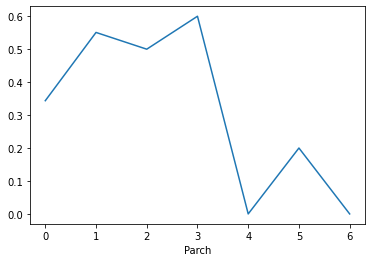

In [27]:
train.groupby("Parch")["Survived"].mean().plot()

<AxesSubplot:xlabel='Cabin'>

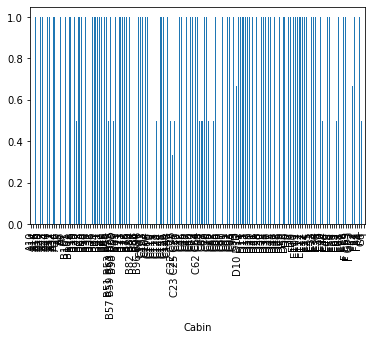

In [30]:
train.groupby("Cabin")["Survived"].mean().plot(kind="bar")

In [31]:
train["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [58]:
def extract_name(x):
    x = x.split("(")[0]
    name1, name2 = x.split(",")
    name2, name3 = name2.split(".")
    return [name1.strip().lower(), name2.strip().lower(), name3.strip().lower()]

In [59]:
train_names = train.Name.apply(extract_name)
test_names = test.Name.apply(extract_name)

In [64]:
train["name1"] = [n[0] for n in train_names]
train["name2"] = [n[1] for n in train_names]
train["name3"] = [n[2] for n in train_names]

test["name1"] = [n[0] for n in test_names]
test["name2"] = [n[1] for n in test_names]
test["name3"] = [n[2] for n in test_names]

In [67]:
train.groupby("name2")["Survived"].agg(["mean", "count"])

,mean,count
name2,,
capt,0.000000,1
col,0.500000,2
don,0.000000,1
dr,0.428571,7
jonkheer,0.000000,1
lady,1.000000,1
major,0.500000,2
master,0.575000,40
miss,0.697802,182


In [76]:
drop_name2 = train.name2.value_counts().to_frame().query("name2<5").index.tolist()

train.loc[train.name2.isin(drop_name2), "name2"] = "other"
test.loc[test.name2.isin(drop_name2), "name2"] = "other"

In [77]:
train.groupby("name2")["Survived"].agg(["mean", "count"])

,mean,count
name2,,
dr,0.428571,7
master,0.575000,40
miss,0.697802,182
mr,0.156673,517
mrs,0.792000,125
other,0.642857,14
rev,0.000000,6


In [82]:
train.drop(["Name", "name1", "name3"], axis=1, inplace=True)
test.drop(["Name", "name1", "name3"], axis=1, inplace=True)

In [83]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,name2
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,mr
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,211536,13.0000,NaN,S,rev
887,888,1,1,female,19.0,0,0,112053,30.0000,B42,S,miss
888,889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,miss
889,890,1,1,male,26.0,0,0,111369,30.0000,C148,C,mr


In [91]:
def extract_ticket(x):
    x = x.split(" ")
    if len(x) > 1:
        prefix = x[0]
        ticket = " ".join(x[1:])
    else:
        prefix = "NULL"
        ticket = x
    return prefix.replace(".", "").lower()

In [92]:
train_ticket = train.Ticket.apply(extract_ticket)
test_ticket = test.Ticket.apply(extract_ticket)

In [95]:
train["Ticket"] = train_ticket
test["Ticket"] = test_ticket

In [98]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
name2            0
dtype: int64

In [99]:
test.isnull().sum()

PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
name2            0
dtype: int64

In [100]:
num_train = len(train)
train_target = train["Survived"].values

train.drop(["PassengerId", "Survived"], axis=1, inplace=True)
test.drop(["PassengerId"], axis=1, inplace=True)

In [101]:
data = pd.concat([train, test], axis=0)

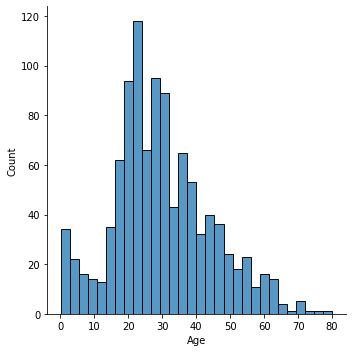

In [105]:
sns.displot(data.Age, bins=30)

In [125]:
data["Age"] = pd.cut(data.Age, bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 100],\
                     labels=[f"age_{i}" for i in range(1, 12)]).astype(str)

In [132]:
data.isnull().sum()

Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin       1014
Embarked       0
name2          0
dtype: int64

In [131]:
data["Fare"] = data.Fare.fillna(data.Fare.median())
data["Embarked"] = data.Embarked.fillna("S")

In [134]:
data["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [137]:
data["Cabin"] = data["Cabin"].apply(lambda x:x[0] if isinstance(x, str) else "null")

In [145]:
data["Fare"] = pd.cut(np.log1p(data.Fare), bins=[0, 2, 3, 4, 5, 8], \
                      labels=[f"fare_{i}" for i in range(1, 6)])

In [149]:
data.loc[data.Parch >= 3, "Parch"] = 3

In [153]:
data = data.rename({"name2": "Name"}, axis=1)

In [161]:
data["Fare"] = data.Fare.astype("str")

In [163]:
one_hot  = OneHotEncoder(drop="first").fit(data)

In [164]:
data_onehot = one_hot.transform(data)

In [167]:
one_hot.categories_

[array([1, 2, 3]),
 array(['female', 'male'], dtype=object),
 array(['age_1', 'age_10', 'age_11', 'age_2', 'age_3', 'age_4', 'age_5',
        'age_6', 'age_7', 'age_8', 'age_9', 'nan'], dtype=object),
 array([0, 1, 2, 3, 4, 5, 8]),
 array([0, 1, 2, 3]),
 array(['a', 'a/4', 'a/5', 'a/s', 'a4', 'a5', 'aq/3', 'aq/4', 'c', 'ca',
        'ca/soton', 'fa', 'fc', 'fcc', 'lp', 'null', 'p/pp', 'pc', 'pp',
        'sc', 'sc/a3', 'sc/a4', 'sc/ah', 'sc/paris', 'sco/w', 'so/c',
        'so/pp', 'soc', 'sop', 'soton/o2', 'soton/oq', 'sp', 'ston/o',
        'ston/o2', 'ston/oq', 'sw/pp', 'w/c', 'we/p', 'wep'], dtype=object),
 array(['fare_1', 'fare_2', 'fare_3', 'fare_4', 'fare_5', 'nan'],
       dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'null'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object),
 array(['dona', 'dr', 'master', 'miss', 'mr', 'mrs', 'other', 'rev'],
       dtype=object)]

In [169]:
train = data_onehot[:num_train, :]
test = data_onehot[num_train:, :]

In [170]:
model = LogisticRegression()
model.fit(train, train_target)

LogisticRegression()

In [171]:
model.predict(test)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [172]:
submission["Survived"] = model.predict(test)

In [173]:
submission.to_csv("./submission.csv", index=False)

## 拓展内容

需要注意的是，逻辑回归虽然存在sigmoid函数将输出结果映射到0～1区间，但本质依然是一个线性模型，因为模型的分类决策边界是一个**平面**，而不是曲面或其他，以下图为例，中间的蓝色直线就是我们的分类（超）平面，位于平面上方的点为正样本，下方的点为负样本，这个分类（超）平面可以用一个线性方程表示出来。

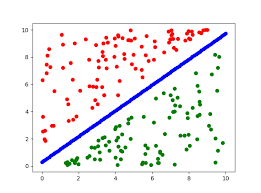

- [广义线性模型](https://zhuanlan.zhihu.com/p/22876460)

## 作业

1. 分类问题中，在正负样本不均衡的情况下，我们如何评价模型？
2. 在[Titanic - Machine Learning from Disaster
](https://www.kaggle.com/competitions/titanic/overview)比赛提交逻辑回归建模预测结果，需要得分高于0.75